In [1]:
import sys
from pathlib import Path
import os
import h5py

import torch
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/DIETNETWORK/")
sys.path.append("/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/DIETNETWORK/Dietnet")
from Dietnet.make_attributions import load_data, load_model
from Dietnet.helpers import dataset_utils as du
from Dietnet.Interpretability import graph_attribution_manager as gam

os.environ["CUDA_VISIBLE_DEVICES"] = "0,2,3"
device = torch.device('cuda:0')

Create graph attribution manager object and initialize all its attributes

In [2]:
which_fold = 0
seed = 23
train_valid_ratio = 0.75

exp_path = Path('/home/rochefortc/shared_disk_wd4tb/rochefortc/Dietnetwork/Dietnet2/1000G_EXP/EXP01_2020.07')
exp_folder = 'REPRODUCE_2020.07'
full_path = exp_path / exp_folder / '{}_fold{}'.format(exp_folder, which_fold)
model_path =  full_path / 'model_params.pt'

dataset = 'dataset.npz'
embedding = 'embedding.npz'
folds_indexes = 'folds_indexes.npz'

#  Get data
test_generator, x_test = load_data(exp_path, dataset, folds_indexes, which_fold, seed, train_valid_ratio, device, batch_size=12)


#  Load embedding
emb = du.load_embedding(os.path.join(exp_path, embedding), which_fold)
emb = emb.to(device)
emb = emb.float()

#  Normalize embedding
emb_norm = (emb ** 2).sum(0) ** 0.5
emb = emb/emb_norm

#  Instantiate model
n_feats_emb = emb.size()[1] # input of aux net
n_feats = emb.size()[0] # input of main net

#  Hidden layers size
n_hidden_u = 100
n_hidden1_u = 100
n_hidden2_u = 100

#  Output layer
n_targets = test_generator.dataset.ys.max().item()+1
input_dropout = 0.

In [3]:
#  attrs file created in make_attributions.ipynb
attr_manager = gam.GraphAttributionManager()
attr_manager.set_device(device)

hf = h5py.File(os.path.join(full_path, 'attrs_avg_true_0.h5'), 'r')
attr_manager.set_agg_attributions(hf['avg_attr'][:, :, :])
attr_manager.set_feat_names(np.load(os.path.join(full_path, 'additional_data.npz'))['feature_names'])
attr_manager.set_label_names(np.load(os.path.join(full_path, 'additional_data.npz'))['label_names'])
attr_manager.set_labels(torch.from_numpy(np.load(os.path.join(full_path, 'additional_data.npz'))['test_labels']))
attr_manager.set_genotypes_data(x_test)
attr_manager.set_data_generator(test_generator)
#attr_manager.set_working_dir('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/results/DietNetworks_experiments')

#  Get model
disc_net = load_model(model_path, emb, device, n_feats_emb, n_hidden_u, n_hidden1_u,  n_hidden2_u, n_targets, input_dropout, incl_bias=True, incl_softmax=True)
attr_manager.set_model(disc_net)
attr_manager.init_attribution_function(attr_type='int_grad', backend='captum')

3 GPUs detected! Running in DataParallel mode
initialized attribution_function. You can call `create_attributions` method once you set model and data_generator


Create attributions for encoded zero baseline (for a single batch)

In [4]:
#  compute attribution for individial values
input_batch, target_batch, _ = next(iter(test_generator))
baseline = test_generator.dataset.xs.min(0).values.view(1,-1)
attr, delta = attr_manager.attr_func.attribute(inputs=(input_batch.to(attr_manager.device)), 
                                               target=target_batch.to(attr_manager.device), 
                                               return_convergence_delta=True, 
                                               n_steps=100,
                                               method='riemann_left',
                                               baselines=baseline)
attr = attr.cpu().numpy()

Function for computing attrubutions on partially changed (0->2) baselines

In [5]:
#  Baseline is same everywhere but at position idx, we switch 0 <-> 2
def switch_pos_compute_attr(idx):
    baseline = test_generator.dataset.xs.min(0).values.view(1,-1)
    baseline[0][idx] = test_generator.dataset.xs.max(0).values.view(1,-1)[0][idx]

    attr2, delta2 = attr_manager.attr_func.attribute(inputs=(input_batch.to(attr_manager.device)), 
                                                 target=target_batch.to(attr_manager.device), 
                                                 return_convergence_delta=True, 
                                                 n_steps=100,
                                                 method='riemann_left',
                                                 baselines=baseline)
    attr2 = attr2.cpu().numpy()
    return attr2

Interpolated attribution values (when modifying a single SNP 0->2). We are only looking at the first 50 SNPs here

In [6]:
attrs_list = []
for i in range(50):
    attrs_list.append(switch_pos_compute_attr([i]))

In [7]:
i=0
print('Zero Baseline')
print(attr[:,i])
print('Attributions with only position {} changed 0->2'.format(i))
print(attrs_list[i][:,i])
print('\n')

Zero Baseline
[-0.0000000e+00 -0.0000000e+00 -0.0000000e+00  5.3463491e-06
  0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00
  0.0000000e+00 -0.0000000e+00 -1.5884047e-05  1.4514496e-06]
Attributions with only position 0 changed 0->2
[ 1.29842892e-05  3.03817542e-05  1.08100503e-05 -5.34634910e-06
 -3.39378203e-05  1.04154415e-05  1.10133979e-05 -3.33335374e-05
 -1.50922779e-05  9.62164904e-06  1.58840467e-05 -1.45144963e-06]




Plot the attributions of the modified baseline vs the zero encoded baseline.

Displaying only the attributions of the modified positions (so only n_batch datapoints to plot per SNP). rows are SNP changed and columns are variants 0,1,2

Notice how variant 0 and 2 behave as expected (as baseline changes from 0->2, attribution of 0 becomes non-zero, and attribution of 2 becomes 0)

/mnt/wd_4tb/shared_disk_wd4tb/grenierj/anaconda2/dietnetwork/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/mnt/wd_4tb/shared_disk_wd4tb/grenierj/anaconda2/dietnetwork/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/mnt/wd_4tb/shared_disk_wd4tb/grenierj/anaconda2/dietnetwork/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/mnt/wd_4tb/shared_disk_wd4tb/grenierj/anaconda2/dietnetwork/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


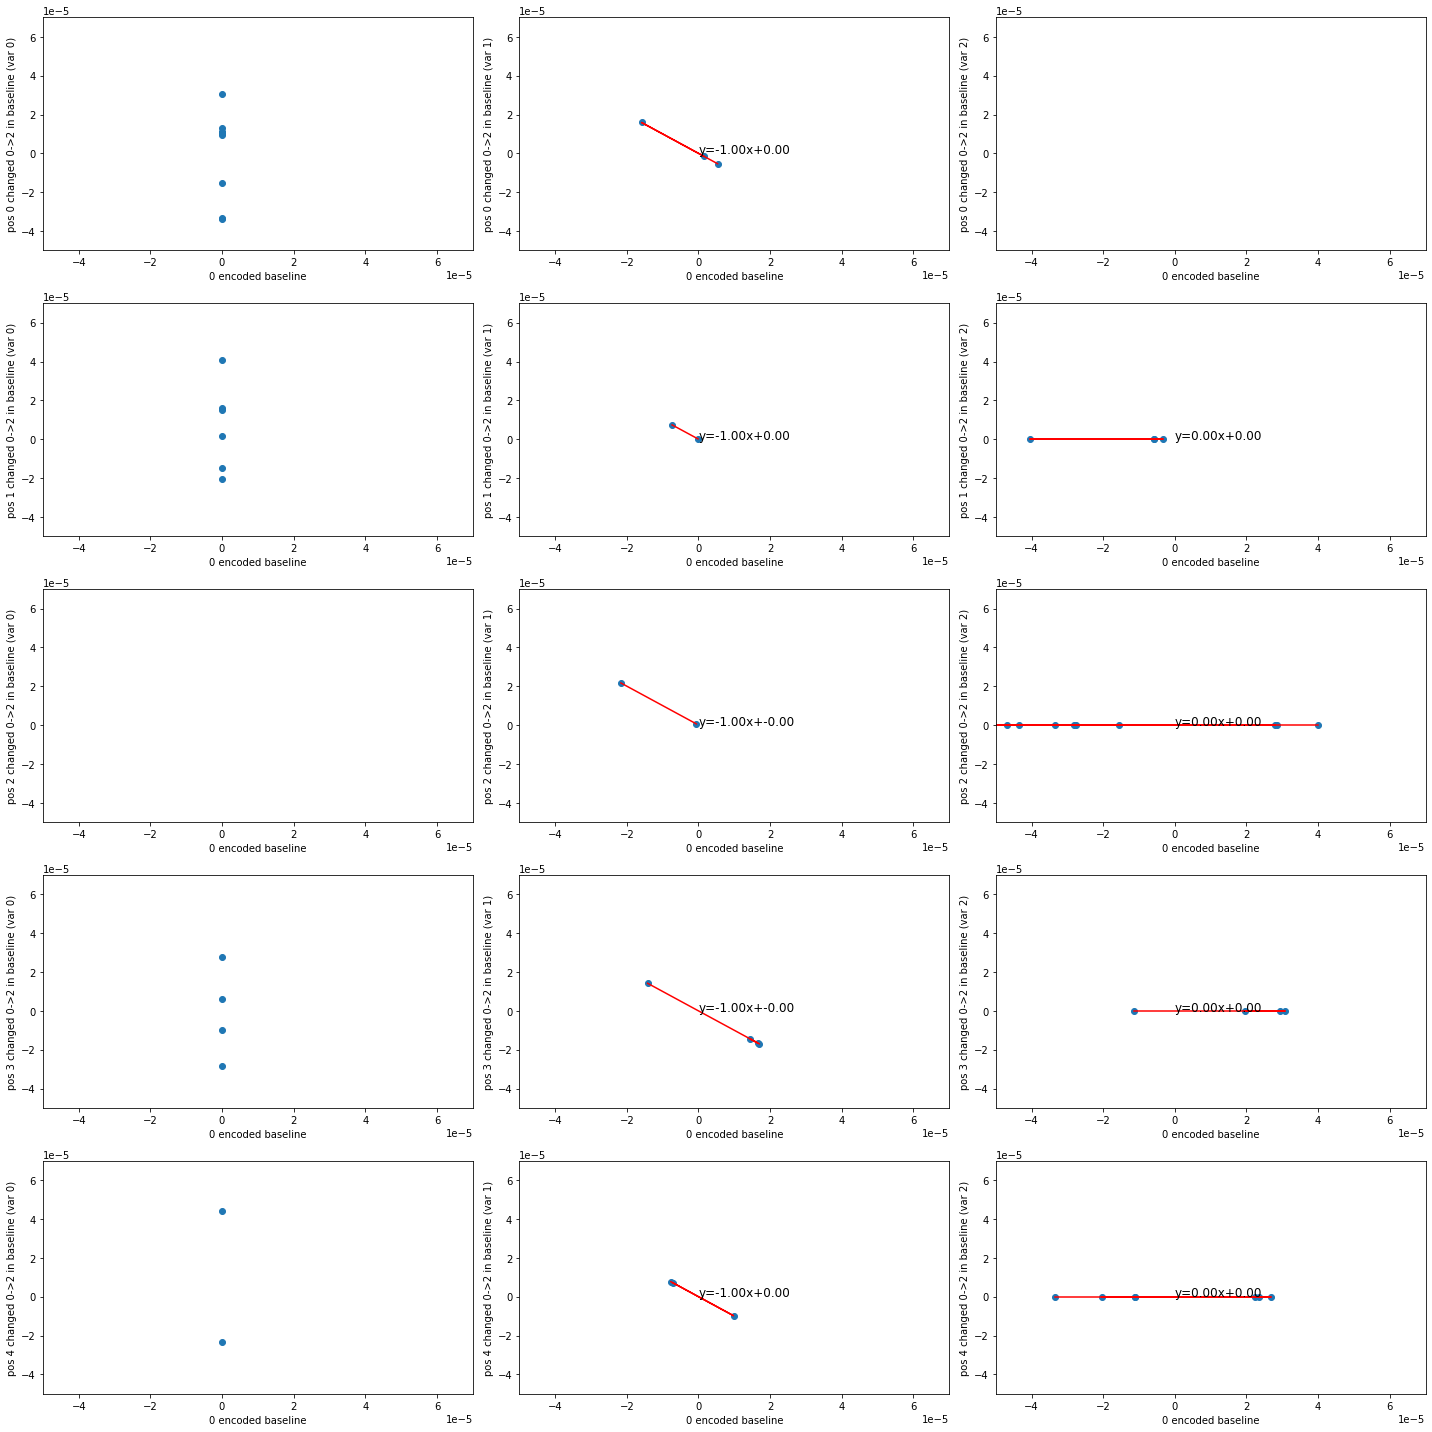

In [12]:
import seaborn as sns

fig, axs = plt.subplots(5, 3, figsize=(20, 20))
for i in range(5):
    for j in range(3):
        ax1 = attr[:,i][(x_test[0:12, i] == j).cpu()]
        ax2 = attrs_list[i][:,i][(x_test[0:12, i] == j).cpu()]
        
        axs[i,j].scatter(ax1, ax2)
        
        try:
            m, b = np.polyfit(ax1, ax2, 1) # m = slope, b = intercept.
            axs[i,j].plot(ax1, m*ax1 + b, color='red') #add line of best fit.
            axs[i,j].text(x=0, y=b, s='y={:.2f}x+{:.2f}'.format(m, b), fontsize=12)
        except:
            pass

        axs[i,j].set_xlabel('0 encoded baseline')
        axs[i,j].set_ylabel(('pos {} changed 0->2 in baseline (var {})'.format(i, j)))
        #axs[i,j].set_title()
        axs[i,j].set_xlim([-5e-5, 7e-5])
        axs[i,j].set_ylim([-5e-5, 7e-5])
        #plt.xticks(rotation=90)
plt.tight_layout()

Same setup as before, but plotting attributions for all 50 SNPs (not just modified positions).

So 50 * n_batch datapoints to plot. Same rows and columns as before

Notice how the (50 * n_batch - n_batch) unaffected SNPs have attributions with correlation ~1 with the zero encoded baseline.

So changing a single SNP doesn't seem to change the attribution of the unchanged SNPs

/mnt/wd_4tb/shared_disk_wd4tb/grenierj/anaconda2/dietnetwork/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/mnt/wd_4tb/shared_disk_wd4tb/grenierj/anaconda2/dietnetwork/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/mnt/wd_4tb/shared_disk_wd4tb/grenierj/anaconda2/dietnetwork/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/mnt/wd_4tb/shared_disk_wd4tb/grenierj/anaconda2/dietnetwork/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/mnt/wd_4tb/shared_disk_wd4tb/grenierj/anaconda2/dietnetwork/lib/python3.6/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


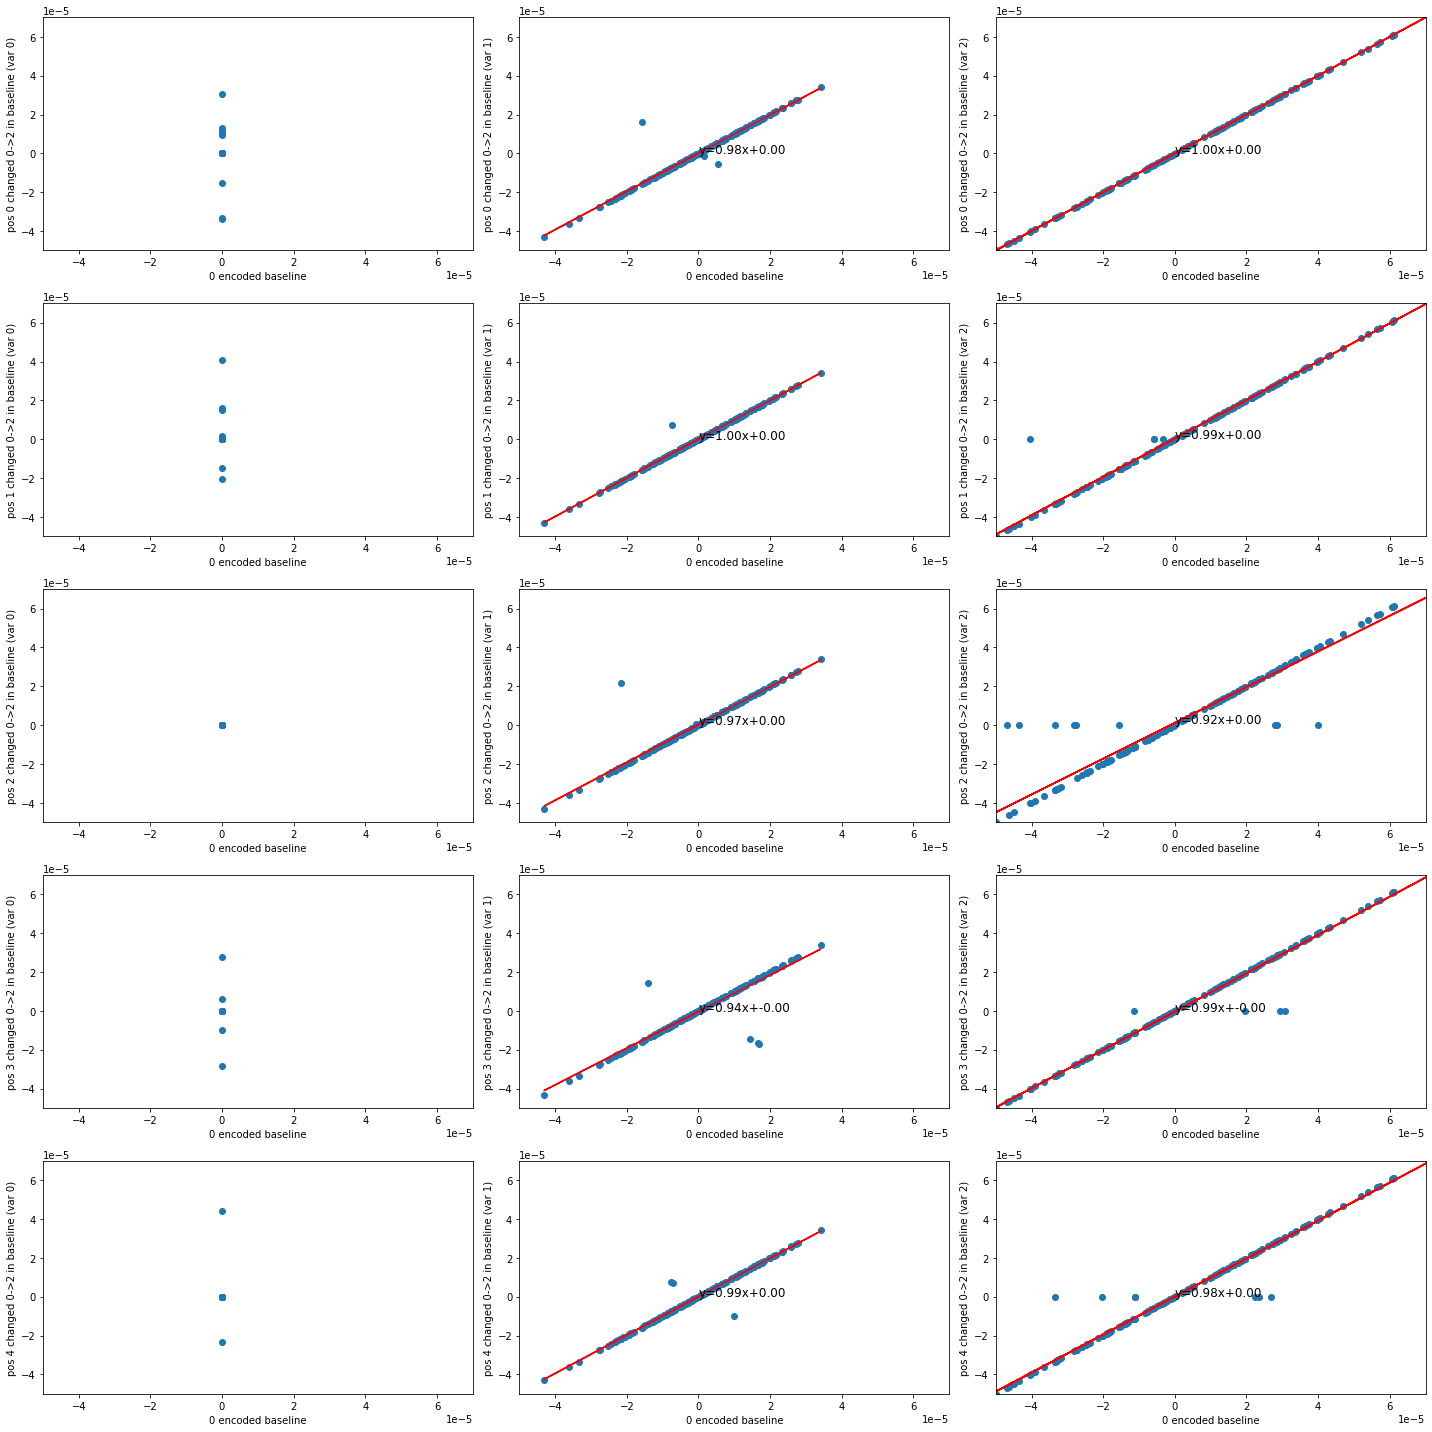

In [13]:
fig, axs = plt.subplots(5, 3, figsize=(20, 20))
for i in range(5):
    for j in range(3):
        ax1 = attr[:,0:50][(x_test[0:12, 0:50] == j).cpu()]
        ax2 = attrs_list[i][:,0:50][(x_test[0:12, 0:50] == j).cpu()]
        axs[i,j].scatter(ax1, ax2)
        
        try:
            m, b = np.polyfit(ax1, ax2, 1) # m = slope, b = intercept.
            axs[i,j].plot(ax1, m*ax1 + b, color='red') #add line of best fit.
            axs[i,j].text(x=0, y=b, s='y={:.2f}x+{:.2f}'.format(m, b), fontsize=12)
        except:
            pass

        axs[i,j].set_xlabel('0 encoded baseline')
        axs[i,j].set_ylabel(('pos {} changed 0->2 in baseline (var {})'.format(i, j)))
        #axs[i,j].set_title()
        axs[i,j].set_xlim([-5e-5, 7e-5])
        axs[i,j].set_ylim([-5e-5, 7e-5])
        #plt.xticks(rotation=90)
plt.tight_layout()

Compute attributions when modifying a subset of SNPs. We go from 0% to 100% 0->2. 

We do this left to right so that each set of modified SNPs contain all the previously modified SNPs.

In [14]:
#  Baseline is same everywhere but at position idx, we switch 0 <-> 2
attrs_list = []
pos_perc = np.arange(50)/50
for perc in pos_perc:
    attrs_list.append(switch_pos_compute_attr(np.arange(294427)[:int(np.floor(perc*294427))]))

We plot only variant 1 for all 50 interpolations. We can clearly see the same anticorrelation pattern as above when we change a few 0->2.

We also see that this pattern becomes more and more inexact as we change > 0->2.

The baseline of all 2's ends up having correlation of -0.61 vs -1 expected.

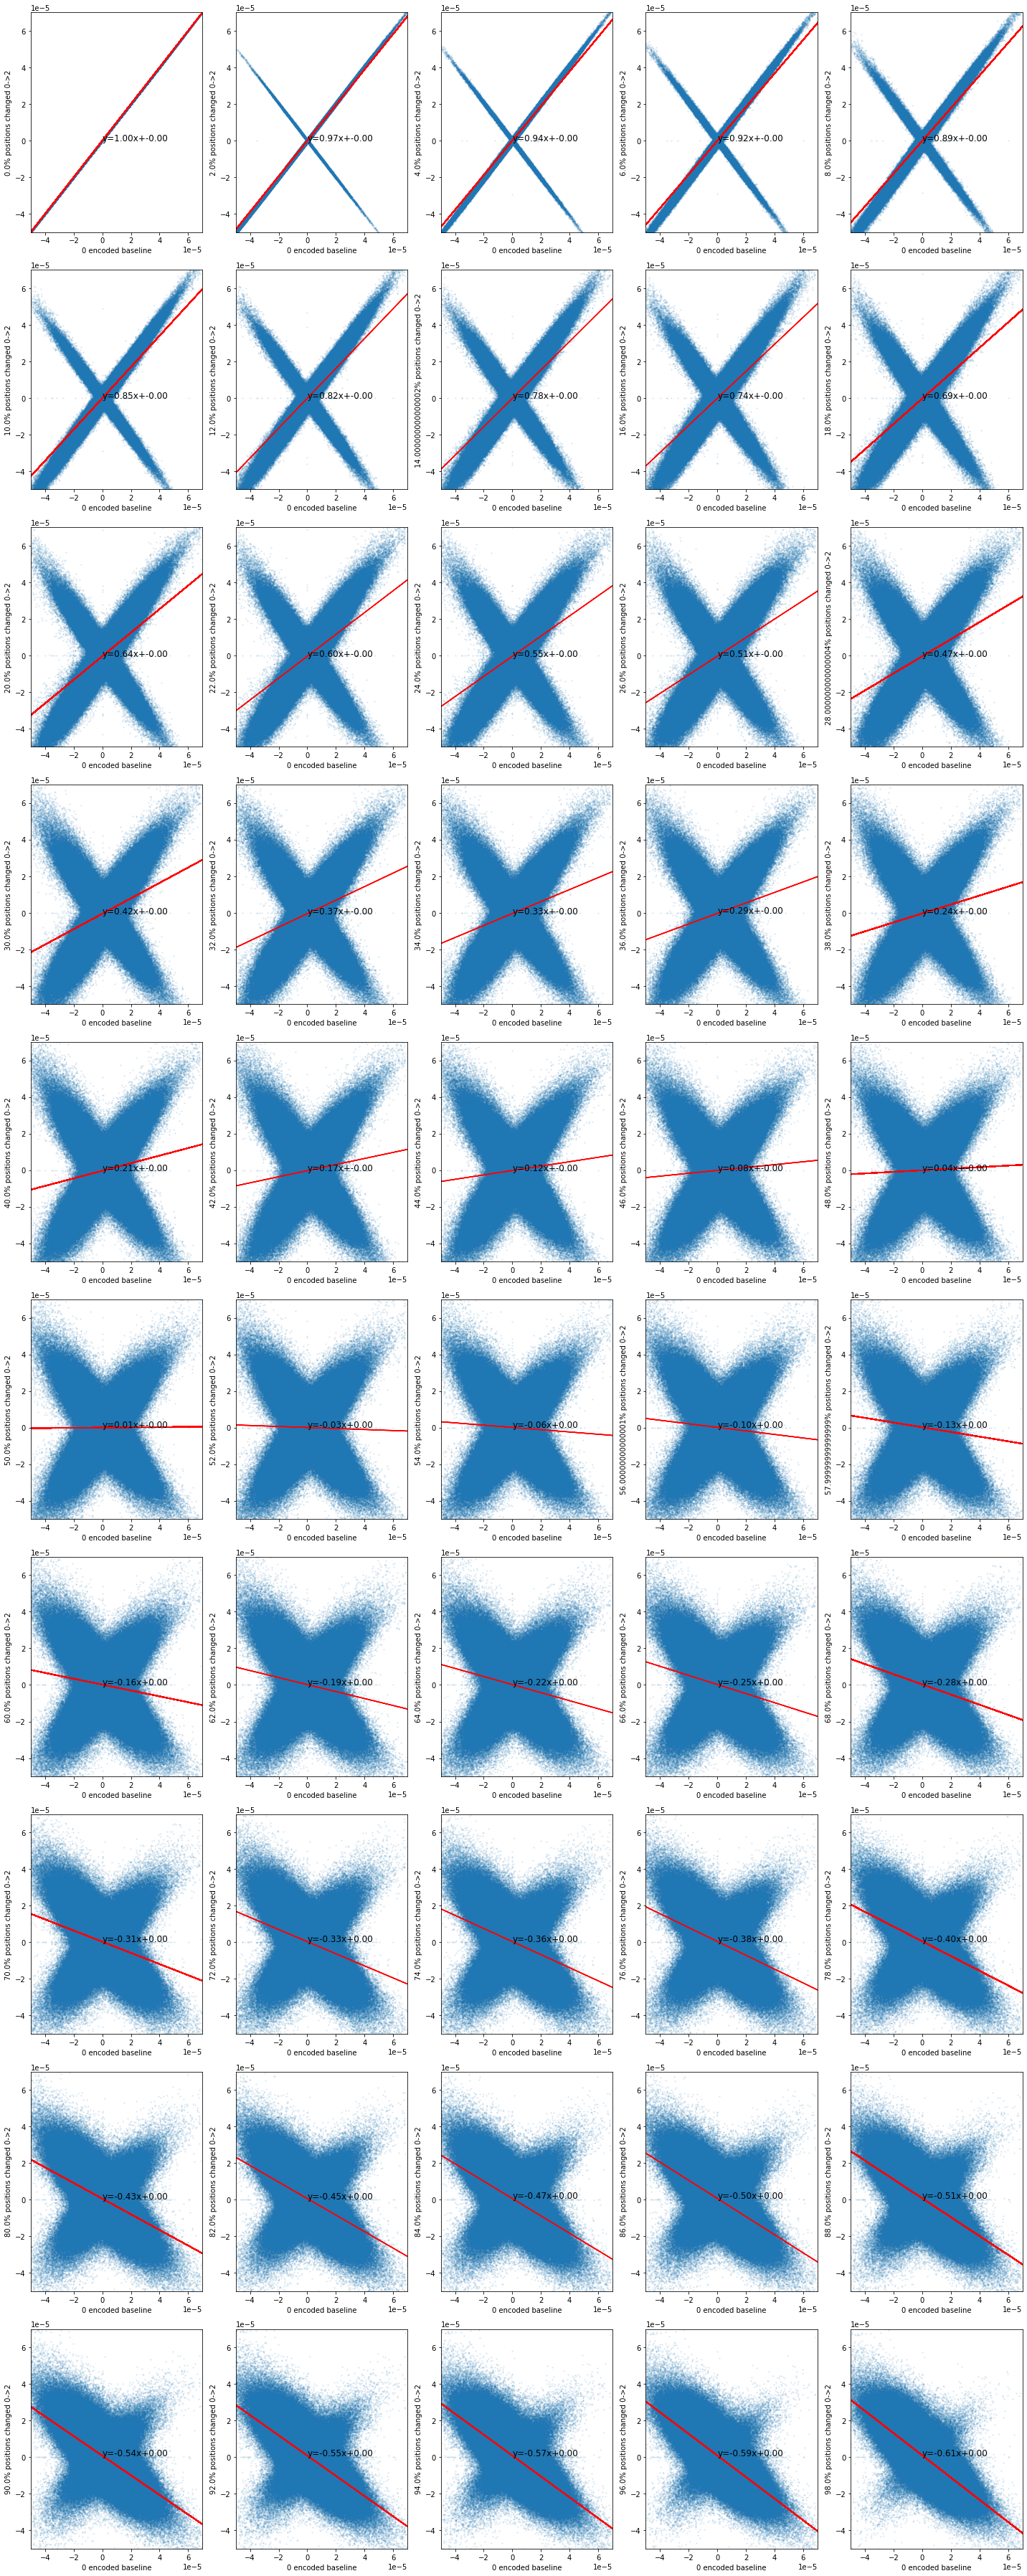

In [15]:
fig, axs = plt.subplots(10, 5, figsize=(20, 50))
indx = 0
for i in range(10):
    for j in range(5):
        ax1 = attr[(x_test[0:12] == 1).cpu()]
        ax2 = attrs_list[indx][(x_test[0:12] == 1).cpu()]
        axs[i,j].scatter(ax1, ax2, s=2, alpha=0.1)
        
        try:
            m, b = np.polyfit(ax1, ax2, 1) # m = slope, b = intercept.
            axs[i,j].plot(ax1, m*ax1 + b, color='red') #add line of best fit.
            axs[i,j].text(x=0, y=b, s='y={:.2f}x+{:.2f}'.format(m, b), fontsize=12)
        except:
            pass

        axs[i,j].set_xlabel('0 encoded baseline')
        axs[i,j].set_ylabel(('{}% positions changed 0->2'.format(pos_perc[indx]*100)))
        #axs[i,j].set_title()
        axs[i,j].set_xlim([-5e-5, 7e-5])
        axs[i,j].set_ylim([-5e-5, 7e-5])
        #plt.xticks(rotation=90)
        indx += 1
plt.tight_layout()
plt.savefig('attrs_baseline_0_to_2')

We want to ensure that the distribution of attributions for each baseline does not lead to issues with our Spearman Correlation metric

Notice how the distribution of aggregated attributions are nice and normal looking!

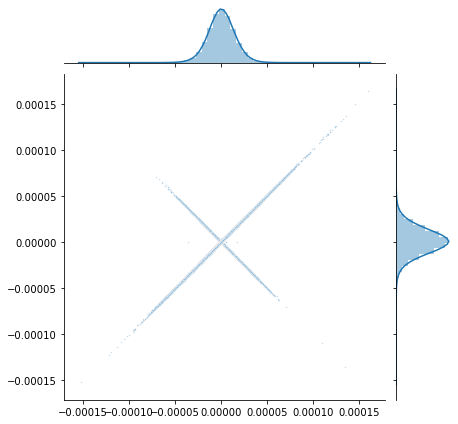

In [24]:
ax1 = attr[(x_test[0:12] == 1).cpu()]
ax2 = attrs_list[1][(x_test[0:12] == 1).cpu()]

g = sns.JointGrid(x=ax1, y=ax2)
g.plot_joint(sns.scatterplot, s=2, alpha=.3)
g.plot_marginals(sns.distplot, kde=True)

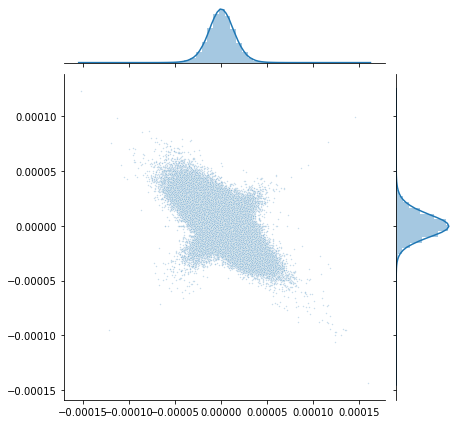

In [25]:
ax1 = attr[(x_test[0:12] == 1).cpu()]
ax2 = attrs_list[-1][(x_test[0:12] == 1).cpu()]

g = sns.JointGrid(x=ax1, y=ax2)
g.plot_joint(sns.scatterplot, s=2, alpha=.3)
g.plot_marginals(sns.distplot, kde=True)